In [1]:
from src.data.dataloader import DataLoader
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
dataloader = DataLoader()
characters = dataloader.load_characters()
movies_with_characters = dataloader.load_movies_with_characters()

def create_dummies_from_list_column(df, column_name):
    # Split the string entries into lists
    split_series = df[column_name].str.split(', ')
    # Create a new DataFrame with dummy variables
    dummy_df = pd.get_dummies(split_series.apply(pd.Series).stack(), prefix=column_name).groupby(level=0).sum()
    # Merge the dummy variables into the original DataFrame
    df = pd.concat([df, dummy_df], axis=1)
    # Drop the original column
    df = df.drop(column_name, axis=1)
    return df

def replace_with_mean_median_std_min_max(df, column_name):
    # Split the ages into lists, cleaning up any whitespace or invalid entries
    df[column_name] = df[column_name].str.split(', ').apply(
        lambda x: [float(age.strip()) for age in x if age.strip().replace('.', '', 1).isdigit()]
    )
    # Calculate mean, median, std, min, and max, handling empty lists
    df[f'{column_name}_mean'] = df[column_name].apply(
        lambda x: sum(x) / len(x) if len(x) > 0 else None
    )
    df[f'{column_name}_median'] = df[column_name].apply(
        lambda x: sorted(x)[len(x) // 2] if len(x) % 2 == 1 else 
        (sorted(x)[len(x) // 2 - 1] + sorted(x)[len(x) // 2]) / 2 if len(x) > 0 else None
    )
    df[f'{column_name}_std'] = df[column_name].apply(
        lambda x: (sum((xi - sum(x) / len(x)) ** 2 for xi in x) / len(x)) ** 0.5 if len(x) > 0 else None
    )
    df[f'{column_name}_min'] = df[column_name].apply(
        lambda x: min(x) if len(x) > 0 else None
    )
    df[f'{column_name}_max'] = df[column_name].apply(
        lambda x: max(x) if len(x) > 0 else None
    )
    # Drop the original column
    df = df.drop(column_name, axis=1)
    return df

c:\Users\amene\Desktop\adap\ada-2024-project-insightmasters24\src\data\dataloader.py:172: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(self.paths["tmdb_movies"])
c:\Users\amene\Desktop\adap\ada-2024-project-insightmasters24\src\data\dataloader.py:172: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(self.paths["tmdb_movies"])
c:\Users\amene\Desktop\adap\ada-2024-project-insightmasters24\src\data\dataloader.py:172: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(self.paths["tmdb_movies"])


In [3]:
df = movies_with_characters.drop(["wikipedia_movie_id", "wikidata_movie_id", "Movie name", "character_name", "plot"], axis=1)
df = df.dropna()
df = df[df["Movie box office revenue"] != 0]

df = create_dummies_from_list_column(df, 'actor_gender')
df = df.drop("actor_gender_", axis=1)
df["F ratio"] = df["actor_gender_F"] / (df["actor_gender_M"]+df["actor_gender_F"])

df = replace_with_mean_median_std_min_max(df, 'actor_age_at_release')
df = replace_with_mean_median_std_min_max(df, 'actor_height_meters')

df_with_countries = create_dummies_from_list_column(df, 'Movie countries')
df = df[df_with_countries["Movie countries_United States of America"] == 1]

df_with_countries = create_dummies_from_list_column(df, 'Movie languages')
df = df[df_with_countries["Movie languages_English Language"] == 1]

df = create_dummies_from_list_column(df, 'ethnicity')
df = create_dummies_from_list_column(df, 'Movie genres')

df = df.drop(["Movie languages", "ethnicity_", "Movie genres_", "Movie countries"], axis=1)
df.dropna(inplace=True)

ethnicity_columns = [col for col in df.columns if col.lower().startswith('ethnicity')]
genre_columns = [col for col in df.columns if col.lower().startswith('movie genres')]

df.head()

,Movie release date,Movie box office revenue,actor_gender_F,actor_gender_M,F ratio,actor_age_at_release_mean,actor_age_at_release_median,actor_age_at_release_std,actor_age_at_release_min,actor_age_at_release_max,...,Movie genres_Vampire movies,Movie genres_War film,Movie genres_Werewolf fiction,Movie genres_Western,Movie genres_Whodunit,Movie genres_Women in prison films,Movie genres_Workplace Comedy,Movie genres_World cinema,Movie genres_Wuxia,Movie genres_Zombie Film
1,1992,21502796.0,3,10,0.230769,33.500000,34.0,7.783530,27.0,56.0,...,0,0,0,0,0,0,0,0,0,1
2,1915,50000000.0,24,32,0.428571,31.142857,29.0,11.413383,12.0,56.0,...,0,1,0,0,0,0,0,0,0,0
3,1982,33139618.0,3,11,0.214286,38.923077,38.0,9.514859,22.0,55.0,...,0,0,0,0,0,0,0,0,0,0
4,1974,119500000.0,2,18,0.100000,46.500000,43.0,9.856470,32.0,70.0,...,0,0,0,1,0,0,0,0,0,0
5,1986,8551228.0,5,10,0.333333,44.909091,50.0,14.002951,19.0,67.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# ethnicity_mapping_request = (
#     "Here is a list of ethnicity columns:\n" +
#     "\n".join(ethnicity_columns) +
#     "\nPlease group them into categories and provide us with the mapping. Don't change the column names, just give all the columns grouped into categories and provide us with the mapping."
# )

# client = openai.Client(api_key="...", base_url="https://fmapi.swissai.cscs.ch")
# res = client.chat.completions.create(
#     model="meta-llama/Meta-Llama-3.1-70B-Instruct",
#     messages=[
#         {
#             "content": ethnicity_mapping_request,
#             "role": "user",
#         }
#     ],
#     stream=True,
# )

# for chunk in res:
#     if len(chunk.choices) > 0 and chunk.choices[0].delta.content:
#         print(chunk.choices[0].delta.content, end="", flush=True)

# genres_mapping_request = (
#     "Here is a list of Movie genre columns:\n" +
#     "\n".join(genre_columns) +
#     "\nPlease group them into categories and provide us with the mapping. Don't change the column names, just give all the columns grouped into categories and provide us with the mapping."
# )

# client = openai.Client(api_key="...", base_url="https://fmapi.swissai.cscs.ch")
# res = client.chat.completions.create(
#     model="meta-llama/Meta-Llama-3.1-70B-Instruct",
#     messages=[
#         {
#             "content": genres_mapping_request,
#             "role": "user",
#         }
#     ],
#     stream=True,
# )

# for chunk in res:
#     if len(chunk.choices) > 0 and chunk.choices[0].delta.content:
#         print(chunk.choices[0].delta.content, end="", flush=True)

In [5]:
ethnicity_mapping = {
    "African Ethnicities": [
        "ethnicity_African Americans", "ethnicity_African people", "ethnicity_Afro-Asians",
        "ethnicity_Afro-Cuban", "ethnicity_Akan people", "ethnicity_Berber",
        "ethnicity_Egyptians", "ethnicity_Nigerian Americans", "ethnicity_Sudanese Arabs",
        "ethnicity_Wolof people", "ethnicity_Xhosa people", "ethnicity_Yoruba people"
    ],
    "Asian Ethnicities": [
        "ethnicity_Asian Americans", "ethnicity_Ashkenazi Jews", "ethnicity_Assyrian people",
        "ethnicity_Bhutia", "ethnicity_Chinese Americans", "ethnicity_Chinese Canadians",
        "ethnicity_Chinese Filipino", "ethnicity_Chinese Jamaicans", "ethnicity_Chinese Singaporeans",
        "ethnicity_Filipino Americans", "ethnicity_Filipino Australians", "ethnicity_Filipino mestizo",
        "ethnicity_Filipino people", "ethnicity_Hmong American", "ethnicity_Indo-Canadians",
        "ethnicity_Indian", "ethnicity_Indian Americans", "ethnicity_Indian diaspora in France",
        "ethnicity_Inuit", "ethnicity_Iranian Americans", "ethnicity_Iranian peoples",
        "ethnicity_Iranians in the United Kingdom", "ethnicity_Japanese Brazilians",
        "ethnicity_Japanese people", "ethnicity_Kashmiri Pandit", "ethnicity_Kiwi",
        "ethnicity_Korean American", "ethnicity_Koreans", "ethnicity_Malaysian Chinese",
        "ethnicity_Manx people", "ethnicity_Punjabis", "ethnicity_Sherpa",
        "ethnicity_Sindhis", "ethnicity_Taiwanese", "ethnicity_Taiwanese Americans",
        "ethnicity_Tamil", "ethnicity_Telugu people", "ethnicity_Thai Americans",
        "ethnicity_Tibetan people", "ethnicity_Vietnamese Americans"
    ],
    "European Ethnicities": [
        "ethnicity_Acadians", "ethnicity_Albanian American", "ethnicity_Albanians",
        "ethnicity_Anglo-Celtic Australians", "ethnicity_Anglo-Irish people", "ethnicity_Argentines",
        "ethnicity_Armenian American", "ethnicity_Armenians", "ethnicity_Ashkenazi Jews",
        "ethnicity_Australian Americans", "ethnicity_Australians", "ethnicity_Austrian Americans",
        "ethnicity_Austrians", "ethnicity_Belgians", "ethnicity_British Americans",
        "ethnicity_British Asian", "ethnicity_British Chinese", "ethnicity_British Indian",
        "ethnicity_British Jews", "ethnicity_British Pakistanis", "ethnicity_Bulgarians",
        "ethnicity_Catalan people", "ethnicity_Croatian Americans", "ethnicity_Croatian Australians",
        "ethnicity_Croatian Canadians", "ethnicity_Croats", "ethnicity_Czech Americans",
        "ethnicity_Czechs", "ethnicity_Danish Americans", "ethnicity_Danish Canadians",
        "ethnicity_Dutch Americans", "ethnicity_Dutch Australian", "ethnicity_Dutch Canadians",
        "ethnicity_English Americans", "ethnicity_English Australian", "ethnicity_English Canadians",
        "ethnicity_Finnish Americans", "ethnicity_Finns", "ethnicity_French Americans",
        "ethnicity_French Canadians", "ethnicity_German Americans", "ethnicity_German Canadians",
        "ethnicity_Greeks", "ethnicity_Hungarian Americans", "ethnicity_Hungarians",
        "ethnicity_Icelanders", "ethnicity_Irish Americans", "ethnicity_Irish Australian",
        "ethnicity_Irish Canadians", "ethnicity_Italians", "ethnicity_Lithuanian American",
        "ethnicity_Norwegian Americans", "ethnicity_Norwegians", "ethnicity_Polish Americans",
        "ethnicity_Polish Australians", "ethnicity_Polish Canadians", "ethnicity_Portuguese",
        "ethnicity_Portuguese Americans", "ethnicity_Russian Americans", "ethnicity_Russians",
        "ethnicity_Scottish Americans", "ethnicity_Scottish Australian", "ethnicity_Swedish Americans",
        "ethnicity_Swedish Canadians", "ethnicity_Swiss", "ethnicity_Ukrainian Americans",
        "ethnicity_Ukrainian Canadians", "ethnicity_Welsh Americans", "ethnicity_Welsh people"
    ],
    "Indigenous American Ethnicities": [
        "ethnicity_Apache", "ethnicity_Blackfoot Confederacy", "ethnicity_Cherokee",
        "ethnicity_Choctaw", "ethnicity_Cree", "ethnicity_Lumbee", "ethnicity_Mohawk people",
        "ethnicity_Native Hawaiians", "ethnicity_Ojibwe", "ethnicity_Omaha people",
        "ethnicity_Sioux"
    ],
    "Jewish Ethnicities": [
        "ethnicity_Ashkenazi Jews", "ethnicity_British Jews", "ethnicity_Israeli Americans",
        "ethnicity_Israelis", "ethnicity_Jewish people", "ethnicity_Lithuanian Jews",
        "ethnicity_Sephardi Jews"
    ],
    "Latin American Ethnicities": [
        "ethnicity_Argentines", "ethnicity_Brazilian Americans", "ethnicity_Brazilians",
        "ethnicity_Cuban Americans", "ethnicity_Cubans", "ethnicity_Dominican Americans",
        "ethnicity_Ecuadorian Americans", "ethnicity_Hispanic", "ethnicity_Mexican Americans",
        "ethnicity_Mexicans", "ethnicity_Panamanian Americans", "ethnicity_Puerto Ricans",
        "ethnicity_Salvadoran Americans", "ethnicity_Uruguayans", "ethnicity_Venezuelan Americans",
        "ethnicity_Venezuelans"
    ],
    "Middle Eastern Ethnicities": [
        "ethnicity_Arabs in Bulgaria", "ethnicity_Iranian Americans", "ethnicity_Iranian peoples",
        "ethnicity_Iranians in the United Kingdom", "ethnicity_Iraqi Americans",
        "ethnicity_Jewish people", "ethnicity_Palestinian Americans", "ethnicity_Syrian Americans",
        "ethnicity_Turkish Americans"
    ],
    "Multiracial and Other Ethnicities": [
        "ethnicity_Afro-Asians", "ethnicity_Eurasia", "ethnicity_Eurasian", "ethnicity_Latino",
        "ethnicity_multiracial people", "ethnicity_names of the Greeks",
        "ethnicity_peoples of the Caucasus", "ethnicity_White Africans of European ancestry",
        "ethnicity_White Americans", "ethnicity_White British", "ethnicity_White Latin American",
        "ethnicity_White South Africans", "ethnicity_Yugoslavs"
    ]
}
movie_genres_mapping = {
    "Action and Thrillers": [
        "Movie genres_Action", "Movie genres_Action Comedy", "Movie genres_Action Thrillers",
        "Movie genres_Action/Adventure", "Movie genres_Crime Thriller", 
        "Movie genres_Thriller", "Movie genres_Suspense"
    ],
    "Comedy and Satire": [
        "Movie genres_Comedy", "Movie genres_Comedy film", "Movie genres_Comedy horror", 
        "Movie genres_Comedy of Errors", "Movie genres_Comedy of manners", 
        "Movie genres_Comedy-drama", "Movie genres_Comedic Western", 
        "Movie genres_Parody", "Movie genres_Satire", "Movie genres_Screwball comedy", 
        "Movie genres_Sex comedy", "Movie genres_Workplace Comedy"
    ],
    "Drama and Melodrama": [
        "Movie genres_Addiction Drama", "Movie genres_Biographical film", "Movie genres_Biography", 
        "Movie genres_Biopic [feature]", "Movie genres_Childhood Drama", 
        "Movie genres_Drama", "Movie genres_Family Drama", "Movie genres_Historical drama", 
        "Movie genres_Marriage Drama", "Movie genres_Melodrama", "Movie genres_Tragedy", 
        "Movie genres_Tragicomedy"
    ],
    "Fantasy and Science Fiction": [
        "Movie genres_Animated cartoon", "Movie genres_Animated Musical", "Movie genres_Animation", 
        "Movie genres_Anime", "Movie genres_Fantasy", "Movie genres_Fantasy Adventure", 
        "Movie genres_Fantasy Comedy", "Movie genres_Fantasy Drama", "Movie genres_Science Fiction", 
        "Movie genres_Sci-Fi Adventure", "Movie genres_Sci-Fi Horror", 
        "Movie genres_Sci-Fi Thriller", "Movie genres_Space opera", "Movie genres_Space western", 
        "Movie genres_Sword and Sandal", "Movie genres_Sword and sorcery", 
        "Movie genres_Sword and sorcery films"
    ],
    "Horror and Supernatural": [
        "Movie genres_Creature Film", "Movie genres_Horror", "Movie genres_Horror Comedy", 
        "Movie genres_Monster", "Movie genres_Monster movie", "Movie genres_Natural horror films", 
        "Movie genres_Psychological horror", "Movie genres_Slasher", "Movie genres_Supernatural", 
        "Movie genres_Vampire movies", "Movie genres_Werewolf fiction", "Movie genres_Zombie Film"
    ],
    "Romance and Relationships": [
        "Movie genres_Romance Film", "Movie genres_Romantic comedy", 
        "Movie genres_Romantic drama", "Movie genres_Romantic fantasy"
    ],
    "Western and Historical": [
        "Movie genres_Epic Western", "Movie genres_Historical Epic", 
        "Movie genres_Revisionist Western", "Movie genres_Spaghetti Western", 
        "Movie genres_Western"
    ],
    "Documentary and Experimental": [
        "Movie genres_Documentary", "Movie genres_Docudrama", "Movie genres_Experimental film", 
        "Movie genres_Filmed Play", "Movie genres_Rockumentary", "Movie genres_Short Film"
    ],
    "Music and Dance": [
        "Movie genres_Concert film", "Movie genres_Musical", 
        "Movie genres_Musical comedy", "Movie genres_Musical Drama"
    ],
    "International and Cultural": [
        "Movie genres_Bollywood", "Movie genres_Chinese Movies", 
        "Movie genres_Filipino Movies", "Movie genres_Japanese Movies", 
        "Movie genres_Korean Movies", "Movie genres_World cinema"
    ],
    "Miscellaneous": [
        "Movie genres_Absurdism", "Movie genres_Acid western", "Movie genres_Adult", 
        "Movie genres_Anthropology", "Movie genres_Archaeology", "Movie genres_Art film", 
        "Movie genres_Avant-garde", "Movie genres_B-Western", "Movie genres_Boxing", 
        "Movie genres_Camp", "Movie genres_Caper story", "Movie genres_Cavalry Film", 
        "Movie genres_Cold War", "Movie genres_Courtroom Comedy", "Movie genres_Courtroom Drama", 
        "Movie genres_Cyberpunk", "Movie genres_Dance", "Movie genres_Detective", 
        "Movie genres_Detective fiction", "Movie genres_Doomsday film", 
        "Movie genres_Educational", "Movie genres_Environmental Science", 
        "Movie genres_Erotic Drama", "Movie genres_Erotic thriller", "Movie genres_Erotica", 
        "Movie genres_Extremes Sports", "Movie genres_Fairy tale", 
        "Movie genres_Family-Oriented Adventure", "Movie genres_Feminist Film", 
        "Movie genres_Film à clef", "Movie genres_Film noir", "Movie genres_Gangster Film", 
        "Movie genres_Gay", "Movie genres_Gay Interest", "Movie genres_Gay Themed", 
        "Movie genres_Gender Issues", "Movie genres_Giallo", "Movie genres_Gothic Film", 
        "Movie genres_Graphic & Applied Arts", "Movie genres_Gross out", "Movie genres_Gulf War", 
        "Movie genres_Hagiography", "Movie genres_Hardcore pornography", 
        "Movie genres_Heaven-Can-Wait Fantasies", "Movie genres_Heavenly Comedy", 
        "Movie genres_Heist", "Movie genres_Hip hop movies", "Movie genres_Historical fiction", 
        "Movie genres_Holiday Film", "Movie genres_Humour", "Movie genres_Hybrid Western", 
        "Movie genres_Illnesses & Disabilities", "Movie genres_Indian Western", 
        "Movie genres_Inspirational Drama", "Movie genres_Instrumental Music", 
        "Movie genres_Interpersonal Relationships", "Movie genres_Inventions & Innovations", 
        "Movie genres_Journalism", "Movie genres_Jukebox musical", "Movie genres_Jungle Film", 
        "Movie genres_Juvenile Delinquency Film", "Movie genres_Kafkaesque", 
        "Movie genres_Language & Literature", "Movie genres_Law & Crime", 
        "Movie genres_Legal drama", "Movie genres_Libraries and librarians", 
        "Movie genres_Live action", "Movie genres_Master Criminal Films", 
        "Movie genres_Media Satire", "Movie genres_Media Studies", "Movie genres_Medical fiction", 
        "Movie genres_Mockumentary", "Movie genres_Monster", "Movie genres_Movie serial", 
        "Movie genres_Movies About Gladiators", "Movie genres_Mumblecore", "Movie genres_Music", 
        "Movie genres_Mystery", "Movie genres_Mythological Fantasy", "Movie genres_Natural disaster", 
        "Movie genres_Neo-noir", "Movie genres_New Hollywood", "Movie genres_News", 
        "Movie genres_Ninja movie", "Movie genres_Northern", "Movie genres_Outlaw", 
        "Movie genres_Outlaw biker film", "Movie genres_Parkour in popular culture", 
        "Movie genres_Period Horror", "Movie genres_Period piece", "Movie genres_Plague", 
        "Movie genres_Point of view shot", "Movie genres_Political cinema", 
        "Movie genres_Political drama", "Movie genres_Political satire", 
        "Movie genres_Political thriller", "Movie genres_Pornographic movie", 
        "Movie genres_Pre-Code", "Movie genres_Prison", "Movie genres_Prison film", 
        "Movie genres_Private military company", "Movie genres_Propaganda film", 
        "Movie genres_Psycho-biddy", "Movie genres_Psychological horror", 
        "Movie genres_Psychological thriller", "Movie genres_Punk rock", "Movie genres_Reboot", 
        "Movie genres_Religious Film", "Movie genres_Remake", "Movie genres_Revisionist Fairy Tale", 
        "Movie genres_Road movie", "Movie genres_Road-Horror", "Movie genres_Rockumentary", 
        "Movie genres_Romantic fantasy", "Movie genres_School story", 
        "Movie genres_Sci-Fi Adventure", "Movie genres_Sci-Fi Horror", 
        "Movie genres_Sci-Fi Thriller", "Movie genres_Social issues", 
        "Movie genres_Social problem film", "Movie genres_Softcore Porn", 
        "Movie genres_Space opera", "Movie genres_Space western", 
        "Movie genres_Spaghetti Western", "Movie genres_Splatter film", "Movie genres_Sports", 
        "Movie genres_Spy", "Movie genres_Stand-up comedy", "Movie genres_Star vehicle", 
        "Movie genres_Statutory rape", "Movie genres_Steampunk", "Movie genres_Stoner film", 
        "Movie genres_Stop motion", "Movie genres_Superhero", "Movie genres_Superhero movie", 
        "Movie genres_Supermarionation", "Movie genres_Surrealism", 
        "Movie genres_Swashbuckler films", "Movie genres_Sword and Sandal", 
        "Movie genres_Sword and sorcery", "Movie genres_Sword and sorcery films", 
        "Movie genres_Teen", "Movie genres_Television movie", 
        "Movie genres_The Netherlands in World War II", "Movie genres_Therimin music", 
        "Movie genres_Time travel", "Movie genres_Travel", "Movie genres_Vampire movies", 
        "Movie genres_War film", "Movie genres_Werewolf fiction", "Movie genres_Whodunit", 
        "Movie genres_Women in prison films", "Movie genres_World cinema", "Movie genres_Wuxia", 
        "Movie genres_Zombie Film"
    ]
}

# Create new columns for each category
for category, columns in ethnicity_mapping.items():
    existing_columns = [col for col in columns if col in df.columns]
    if existing_columns:
        df[category] = df[existing_columns].sum(axis=1)

for category, genres in movie_genres_mapping.items():
    existing_columns = [col for col in genres if col in df.columns]
    if existing_columns:
        df[category] = df[existing_columns].sum(axis=1)

# Drop the original ethnicity columns
df = df.drop(columns=ethnicity_columns, axis=1)
df = df.drop(columns=genre_columns, axis=1)

print("Dataset with grouped ethnicity-genre columns:")
df.head()

Dataset with grouped ethnicity-genre columns:


,Movie release date,Movie box office revenue,actor_gender_F,actor_gender_M,F ratio,actor_age_at_release_mean,actor_age_at_release_median,actor_age_at_release_std,actor_age_at_release_min,actor_age_at_release_max,...,Comedy and Satire,Drama and Melodrama,Fantasy and Science Fiction,Horror and Supernatural,Romance and Relationships,Western and Historical,Documentary and Experimental,Music and Dance,International and Cultural,Miscellaneous
1,1992,21502796.0,3,10,0.230769,33.500000,34.0,7.783530,27.0,56.0,...,1,0,1,3,0,0,0,0,0,3
2,1915,50000000.0,24,32,0.428571,31.142857,29.0,11.413383,12.0,56.0,...,0,1,0,0,0,0,0,0,0,1
3,1982,33139618.0,3,11,0.214286,38.923077,38.0,9.514859,22.0,55.0,...,0,1,1,0,0,0,0,0,1,3
4,1974,119500000.0,2,18,0.100000,46.500000,43.0,9.856470,32.0,70.0,...,2,0,0,0,0,1,0,0,0,0
5,1986,8551228.0,5,10,0.333333,44.909091,50.0,14.002951,19.0,67.0,...,0,0,0,0,0,0,0,0,0,1


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

# Split data
X = df.drop("Movie box office revenue", axis=1)
y = df["Movie box office revenue"]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

poly = PolynomialFeatures(degree=3, include_bias=False)
xtrain = poly.fit_transform(xtrain)
xtest = poly.transform(xtest)

# Scale features
x_scaler = StandardScaler()
xtrain = x_scaler.fit_transform(xtrain)
xtest = x_scaler.transform(xtest)

y_scaler = StandardScaler()
ytrain = y_scaler.fit_transform(ytrain.values.reshape(-1, 1)).ravel()

In [101]:
model = Ridge(alpha=100.0)

model.fit(xtrain, ytrain)

Ridge(alpha=100.0)

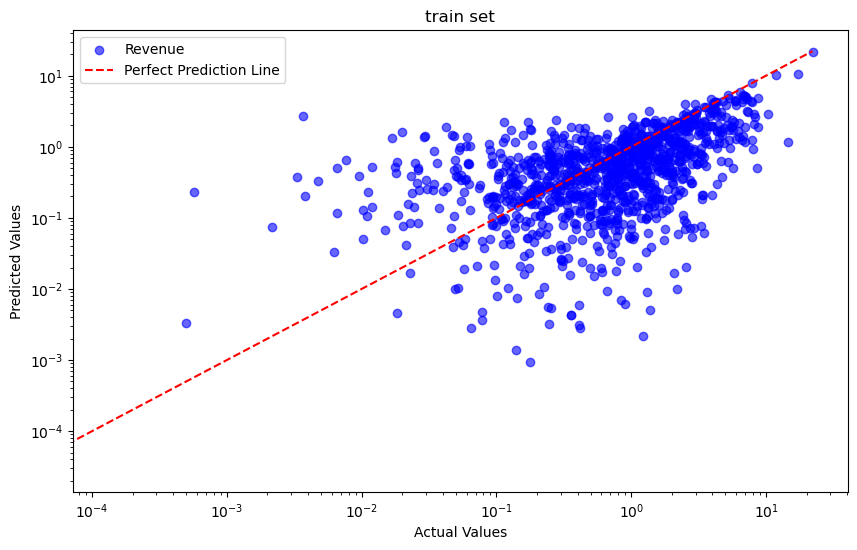

In [102]:
ypred_train = model.predict(xtrain)

plt.figure(figsize=(10, 6))

plt.scatter(ytrain, ypred_train, alpha=0.6, label="Revenue", color="blue")
plt.plot([ytrain.min(), ytrain.max()], [ytrain.min(), ytrain.max()], 'r--', label="Perfect Prediction Line")

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("train set")
plt.legend()
plt.show()

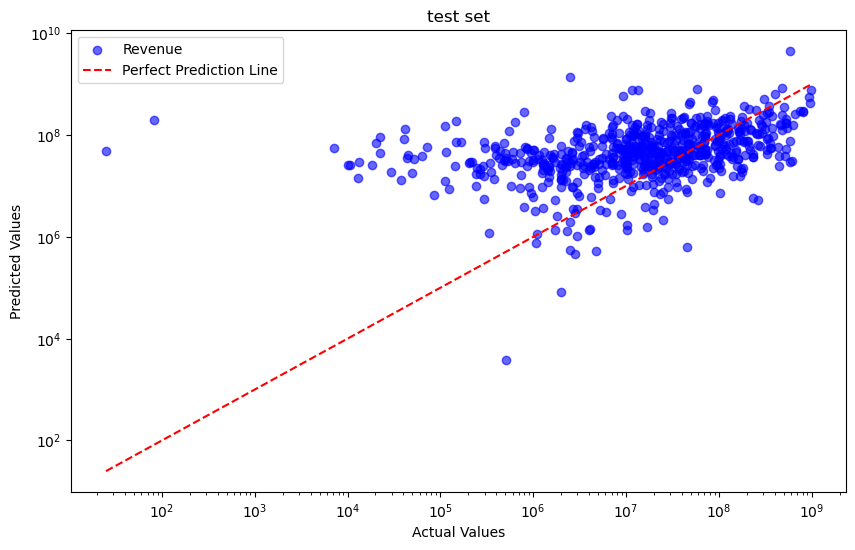

In [103]:
# Predict on the test set
ypred = model.predict(xtest)

ypred = y_scaler.inverse_transform(ypred.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 6))
plt.scatter(ytest, ypred, alpha=0.6, label="Revenue", color="blue")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', label="Perfect Prediction Line")

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("test set")
plt.legend()
plt.show()